In [1]:
from __future__ import print_function
import argparse
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import pathlib
from moltraffic.visualisations import station_error_boxplot, error_distribution, mean_error_over_time, \
    error_distribution_over_time
import matplotlib.dates as mdates
import datetime as dt

def actual_vs_predicted_series(diff_data, hour, minute, station, output_dir=None, fig_type='pdf', fig_size=None):
    v1 = sorted([(t, a) for (e, p, a, t, r) in diff_data if r == station and t.hour == hour and t.minute == minute])
    v2 = sorted([(t, p) for (e, p, a, t, r) in diff_data if r == station and t.hour == hour and t.minute == minute])
    number_of_times = len([x[0] for x in v1])
    if fig_size is None:
        sns.set(rc={'figure.figsize': (int(number_of_times/10), 10)})
    else:
        sns.set(rc={'figure.figsize': fig_size})
    plt.plot([x[0] for x in v1], [x[1] for x in v1], label='actual')
    plt.plot([x[0] for x in v2], [x[1] for x in v2], label='predicted')
    plt.legend()
    if output_dir is None:
        plt.show()
    else:
        pathlib.Path(output_dir).mkdir(parents=True, exist_ok=True)
        plt.savefig(output_dir + f'/{hour}_{minute}_{station}.{fig_type}', bbox_inches='tight', pad_inches=0)
    plt.clf()
    return v1, v2

model_name = 'PytorchWideWideDeepEnsemble10RegressorModel'
station = 'SUM(1006-22a:Smer 1: AC priključek > Ulica bratov Komel)'

In [2]:
predictions_file = f'../models/test_predictions/{model_name}/subset_1_1_2019_run_1.csv'
df = pd.read_csv(predictions_file, compression='gzip')
df['Time'] = pd.to_datetime(df['Time'])

columns_pred = [x.replace('_pred', '') for x in df.columns if x.endswith('_pred')]
columns_actual = [x.replace('_actual', '') for x in df.columns if x.endswith('_actual')]

columns = sorted(list(set(columns_pred).intersection(set(columns_actual))))
diff_columns = []
for c in columns:
    df[f'{c}_diff'] = df[f'{c}_pred'] - df[f'{c}_actual']
    diff_columns.append(f'{c}_diff')
df_diff = df[['Time'] + [x for x in df.columns if x.endswith('_diff')]]

d = df_diff.melt(id_vars=['Time'], value_vars=diff_columns).dropna()
d['Year'] = d['Time'].dt.hour
d['Day'] = d['Time'].dt.minute
d['Time'] = pd.to_datetime(d['Day'].apply(str) + '/' + d['Year'].apply(str), format='%M/%H')


columns = sorted(list(set(columns_pred).intersection(set(columns_actual))))
diff_data = []
for c in columns:
    diff = list(abs(df[f'{c}_pred'] - df[f'{c}_actual']))
    pred = list(df[f'{c}_pred'])
    actual = list(df[f'{c}_actual'])
    times = list(df['Time'])
    diff_data.extend(zip(diff, pred, actual, times, [c] * len(times)))

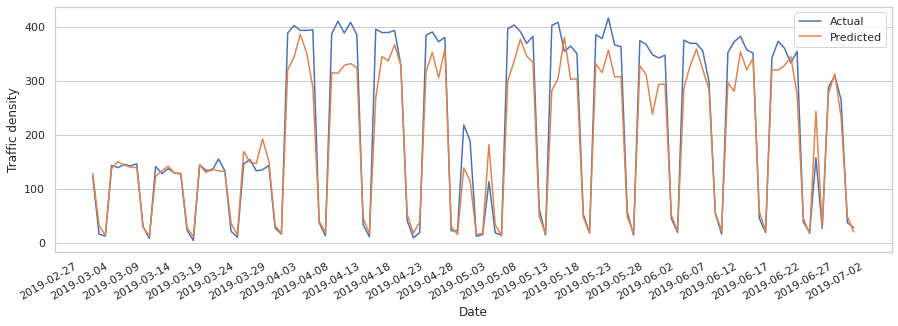

In [3]:
sns.set_theme(style="whitegrid")

plt.figure(figsize=(15,5))

hour, minute = 6, 0
diff_data_sub = [x for x in diff_data if 2<x[3].month<7]
v1 = sorted([(t, a) for (e, p, a, t, r) in diff_data_sub if r == station and t.hour == hour and t.minute == minute])
v2 = sorted([(t, p) for (e, p, a, t, r) in diff_data_sub if r == station and t.hour == hour and t.minute == minute])

plt.plot([x[0] for x in v1], [x[1] for x in v1], label='Actual')
plt.plot([x[0] for x in v2], [x[1] for x in v2], label='Predicted')

plt.xlabel('Date')
plt.ylabel('Traffic density')

plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
plt.gca().xaxis.set_major_locator(mdates.DayLocator(interval=5))

plt.gcf().autofmt_xdate()
plt.legend()
plt.grid(axis='x')

#plt.savefig(f'{station.replace(" ", "_")}_{hour}_{mins}.pdf', bbox_inches='tight', pad_inches=0)

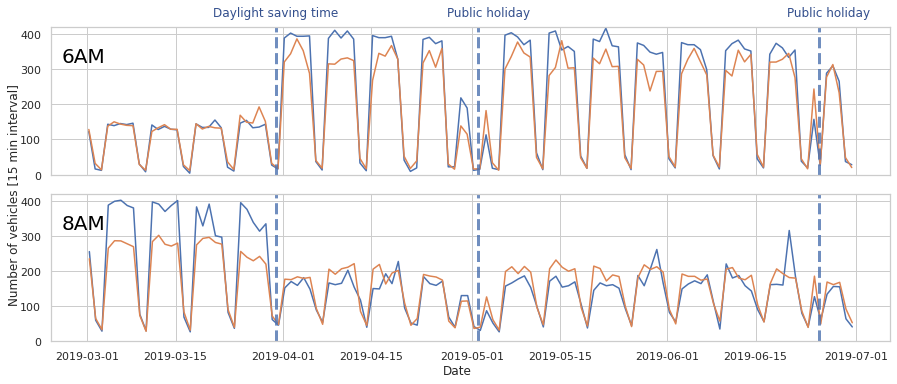

In [4]:
import matplotlib.pyplot as plt


diff_data_sub = [x for x in diff_data if 2<x[3].month<7]

fig, axs = plt.subplots(2, 1, figsize=(12.5, 5), sharex=True)

hour, minute = 6, 0
v1 = sorted([(t, a) for (e, p, a, t, r) in diff_data_sub if r == station and t.hour == hour and t.minute == minute])
v2 = sorted([(t, p) for (e, p, a, t, r) in diff_data_sub if r == station and t.hour == hour and t.minute == minute])

axs[0].plot([x[0] for x in v1], [x[1] for x in v1], label='Actual')
axs[0].plot([x[0] for x in v2], [x[1] for x in v2], label='Predicted')

axs[0].set_ylim([0, 420])

hour, minute = 8, 0
v1 = sorted([(t, a) for (e, p, a, t, r) in diff_data_sub if r == station and t.hour == hour and t.minute == minute])
v2 = sorted([(t, p) for (e, p, a, t, r) in diff_data_sub if r == station and t.hour == hour and t.minute == minute])

axs[1].plot([x[0] for x in v1], [x[1] for x in v1], label='Actual')
axs[1].plot([x[0] for x in v2], [x[1] for x in v2], label='Predicted')

axs[1].set_ylim([0, 420])

fig.tight_layout()



x_line_annotation = dt.datetime(2019, 3, 31)
x_text_annotation = dt.datetime(2019, 3, 21)

axs[0].axvline(x=x_line_annotation, linestyle='dashed', alpha=0.8, linewidth=3)
axs[1].axvline(x=x_line_annotation, linestyle='dashed', alpha=0.8, linewidth=3)
axs[0].text(x=x_text_annotation, y=450, s='Daylight saving time', color='#334f8d')

x_line_annotation = dt.datetime(2019, 5, 2)
x_text_annotation = dt.datetime(2019, 4, 27)

axs[0].axvline(x=x_line_annotation, linestyle='dashed', alpha=0.8, linewidth=3)
axs[1].axvline(x=x_line_annotation, linestyle='dashed', alpha=0.8, linewidth=3)
axs[0].text(x=x_text_annotation, y=450, s='Public holiday', color='#334f8d')

x_line_annotation = dt.datetime(2019, 6, 25)
x_text_annotation = dt.datetime(2019, 6, 20)

axs[0].axvline(x=x_line_annotation, linestyle='dashed', alpha=0.8, linewidth=3)
axs[1].axvline(x=x_line_annotation, linestyle='dashed', alpha=0.8, linewidth=3)
axs[0].text(x=x_text_annotation, y=450, s='Public holiday', color='#334f8d')

#axs[0].set_title('6 AM')
#axs[1].set_title('8 AM')
x_text_annotation = dt.datetime(2019, 2, 25)
axs[0].text(x=x_text_annotation, y=320, s='6AM', color='black', fontsize=20)
axs[1].text(x=x_text_annotation, y=320, s='8AM', color='black', fontsize=20)


#axs[0].fill_between(0, 1, color='green', alpha=0.5)

fig.text(0.0, 0.5, 'Number of vehicles [15 min interval]', va='center', rotation='vertical')
fig.text(0.5, 0.00, 'Date', ha='center')

plt.savefig(f'pred_vs_actual_6_8_am.pdf', bbox_inches='tight', pad_inches=0)

In [5]:
#hour, mins = 8, 0
#diff_data_sub = [x for x in diff_data if 2<x[3].month<6]
#actual_vs_predicted_series(diff_data_sub, hour, mins, station, fig_size=(30,10), output_dir='.')
#plt.savefig(f'{station.replace(" ", "_")}_{hour}_{mins}.pdf', bbox_inches='tight', pad_inches=0)

In [6]:
#df[['Time', 'SUM(1021-156:Prehitevalni pas: AC prikljucek > Tbilisijska)_actual', 'SUM(1021-156:Prehitevalni pas: AC prikljucek > Tbilisijska)_pred']]


#ax = df[selector].plot(x='Time', y='SUM(1021-156:Prehitevalni pas: AC prikljucek > Tbilisijska)_actual')
#df[selector].plot(x='Time', y='SUM(1021-156:Prehitevalni pas: AC prikljucek > Tbilisijska)_pred', ax=ax)
#plt.savefig(f'actual_vs_predicted_march.pdf', bbox_inches='tight', pad_inches=0)

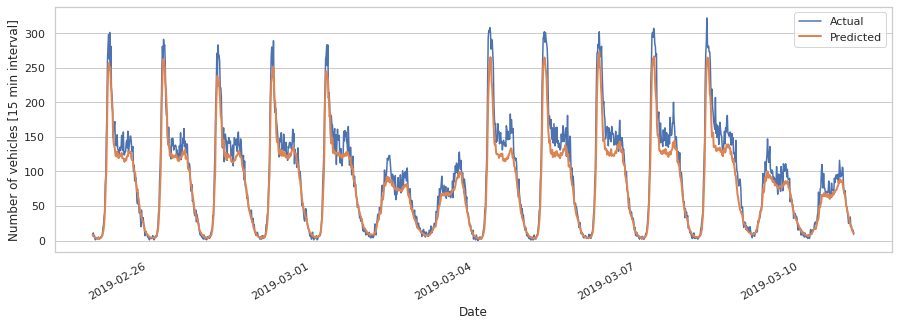

In [7]:
sns.set_theme(style="whitegrid")

selector = (df['Time'].dt.isocalendar().week>8) & (df['Time'].dt.isocalendar().week<11)

min_time = df[selector]['Time'].min()
max_time = df[selector]['Time'].max()
days = mdates.drange(min_time, max_time + dt.timedelta(minutes=15), dt.timedelta(minutes=15))

actual = df[selector]['SUM(1021-156:Prehitevalni pas: AC prikljucek > Tbilisijska)_actual']
pred = df[selector]['SUM(1021-156:Prehitevalni pas: AC prikljucek > Tbilisijska)_pred']

plt.figure(figsize=(15,5))
plt.plot(days, actual, label='Actual')
plt.plot(days, pred, label='Predicted', linewidth=2)
plt.xlabel('Date')
plt.ylabel('Number of vehicles [15 min interval]')

plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
plt.gca().xaxis.set_major_locator(mdates.DayLocator(interval=3))

plt.gcf().autofmt_xdate()
plt.legend()
plt.grid(axis='x')
plt.savefig(f'actual_vs_predicted_march.pdf', bbox_inches='tight', pad_inches=0)

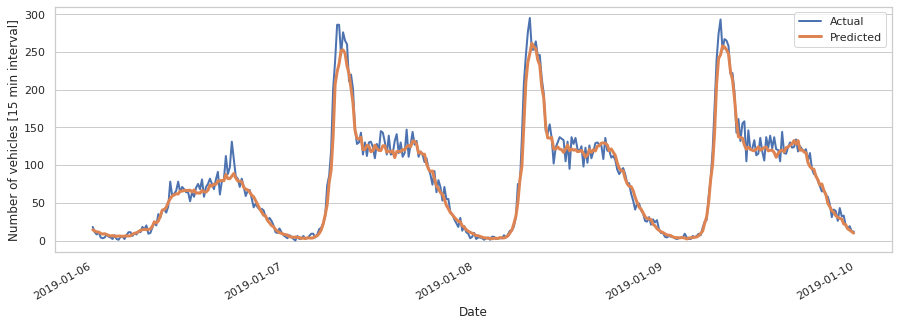

In [8]:
sns.set_theme(style="whitegrid")

selector = (df['Time'].dt.day_of_year>5) & (df['Time'].dt.day_of_year<10)

min_time = df[selector]['Time'].min()
max_time = df[selector]['Time'].max()
days = mdates.drange(min_time, max_time + dt.timedelta(minutes=15), dt.timedelta(minutes=15))

actual = df[selector]['SUM(1021-156:Prehitevalni pas: AC prikljucek > Tbilisijska)_actual']
pred = df[selector]['SUM(1021-156:Prehitevalni pas: AC prikljucek > Tbilisijska)_pred']

plt.figure(figsize=(15,5))
plt.plot(days, actual, label='Actual', linewidth=2)
plt.plot(days, pred, label='Predicted', linewidth=3)
plt.xlabel('Date')
plt.ylabel('Number of vehicles [15 min interval]')

plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
plt.gca().xaxis.set_major_locator(mdates.DayLocator(interval=1))

plt.gcf().autofmt_xdate()
plt.legend()
plt.grid(axis='x')
plt.savefig(f'actual_vs_predicted_one_day.pdf', bbox_inches='tight', pad_inches=0)